---
title: "Test 2: Recommender Systems"
subtitle: "Machine Learning III: Unsupervised and Network Analysis"
date: "9 April 2024"
author: 
  -  María del Valle Varo García


---
---

`fill here your name`

::: {.callout-important icon=false}

No puedes utilizar ChatGPT, pero tienes pleno acceso a Internet; no dudes en utilizarlo, ya que suele ser mucho más útil para programar, mirar documentación o resolver errores de código.
:::

::: {.callout-warning icon=false}

Evita dedicar tiempo a generar código o gráficas no solicitadas. 

No se evaluarán y sólo servirán para consumir tiempo del examen.
:::

---

# **Análisis de ratings a Video Juegos**
### Utilizando la base de datos proporcionada que contiene información sobre usuarios, videojuegos y las calificaciones otorgadas por los usuarios a los videojuegos, realiza las siguientes tareas:




::: {.callout-tip icon="false}
### Question 0 (0.25 points)
Carga los datos como un objeto **panda.DataFrame**.
:::

In [2]:
import numpy as np
import pandas as pd
import cornac
from cornac.eval_methods import RatioSplit
from cornac.models import UserKNN, ItemKNN

FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.


In [3]:
dataset = pd.read_csv("reduced_video_games.csv")

In [4]:
dataset.head()

,userId,productId,rating
0,A2BQXTSS8G6ZL2,B001TOQ8UW,5.0
1,AEJZHD61JTJKK,B0029LJIFG,5.0
2,A3TY2AEFHQRTWJ,B003O6E1JS,4.0
3,A8RITE7SJ9GYS,B0000E5U6I,3.0
4,A1SCCUZEPM657Y,B00DJFIMW6,5.0





::: {.callout-tip icon="false}
### Question 1 (0.75 points)
Filtra el conjunto de datos y conserva sólo los productos que hayan sido valorados al menos 20 veces **en cada una de las cateogorías de ratings**.

:::

In [5]:
reviews_per_rating = dataset[["productId", "rating"]].value_counts()
select_product = (reviews_per_rating >= 20).groupby("productId").all()
select_product = select_product.index[select_product].to_list()
df = dataset.loc[dataset["productId"].isin(select_product)]
df.shape

(11405, 3)

::: {.callout-tip icon="false}

### Question 2 (0.25 points)

¿Qué porcentaje de los datos (ya filtrados) tiene una calificación de 4 o superior?

:::

In [6]:
df.value_counts("rating", normalize=True)

rating
5.0    0.496361
1.0    0.208680
4.0    0.150460
3.0    0.078211
2.0    0.066287
Name: proportion, dtype: float64

In [7]:
(
    df.value_counts("rating", normalize=True).values[0]
    + df.value_counts("rating", normalize=True).values[2]
)

0.646821569487067

::: {.callout-tip icon="false}
### Question 3 (0.25 points)

¿Cuántos usuarios únicos y productos hay?

:::

In [8]:
# Numer of unique users and products
n_users = df["userId"].nunique()
print("UNIQUE USERS: ", n_users)
n_products = df["productId"].nunique()
print("UNIQUE PRODUCTS: ", n_products)

UNIQUE USERS:  11331
UNIQUE PRODUCTS:  20


::: {.callout-tip icon="false}
### Question 4 (0.25 points)

¿Qué porcentaje de valores atípicos hay?

:::

In [9]:
from matplotlib.cbook import boxplot_stats
import seaborn as sns


def explore_outliers(df, num_vars):
    outliers_df = dict()
    for k in range(len(num_vars)):
        var = num_vars[k]
        sns.boxplot(df, x=var)
        outliers_df[var] = boxplot_stats(df[var])[0]["fliers"]
        out_pos = np.where(df[var].isin(outliers_df[var]))[0].tolist()
        out_idx = [df[var].index.tolist()[k] for k in out_pos]
        outliers_df[var] = {
            "values": outliers_df[var],
            "positions": out_pos,
            "indices": out_idx,
        }
    return outliers_df

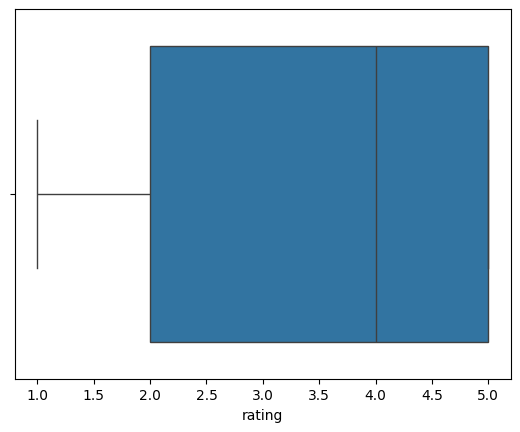

In [10]:
out_XTR = explore_outliers(df, ["rating"])

In [11]:
print("Percetage of outliers", len(out_XTR.get("rating").get("indices")) / len(df))

Percetage of outliers 0.0


::: {.callout-tip icon="false}
### Question 5 (1 points)

¿Cuál es la dispersión (sparsity) del conjunto de datos antes y después de filtrar los productos con más de 20 valoraciones? 

¿Es de esperar que los recomendadores memory-based funcionen mejor que los model-based conociendo ahora la dispersión?


:::

In [12]:
def print_sparsity(df):
    n_users = df.userId.nunique()
    n_items = df.productId.nunique()
    n_ratings = len(df)
    rating_matrix_size = n_users * n_items
    sparsity = 1 - n_ratings / rating_matrix_size

    print(f"Number of users: {n_users}")
    print(f"Number of items: {n_items}")
    print(f"Number of available ratings: {n_ratings}")
    print(f"Number of all possible ratings: {rating_matrix_size}")
    print("-" * 40)
    print(f"SPARSITY: {sparsity * 100.0:.2f}%")


print_sparsity(df)
print_sparsity(dataset)

Number of users: 11331
Number of items: 20
Number of available ratings: 11405
Number of all possible ratings: 226620
----------------------------------------
SPARSITY: 94.97%
Number of users: 206770
Number of items: 31263
Number of available ratings: 250000
Number of all possible ratings: 6464250510
----------------------------------------
SPARSITY: 100.00%




::: {.callout-tip icon="false}
### Question 6 (0.75 points)

¿Cuál es el producto menos valorado? ¿Cuántas veces ha sido valorado?


:::

In [13]:
popular_products = pd.DataFrame(df.groupby("productId")["rating"].count())
least_popular = popular_products.sort_values("rating", ascending=True)
least_popular.iloc[0]

rating    22
Name: B00001OWYW, dtype: int64

::: {.callout-tip icon=true}

### Question 7 (0.75 points)

Haz un histograma de las valoraciones del segundo producto más valorado.

¿Cuál es la valoración media de este producto entre todos los usuarios?

:::

In [14]:
least_popular.iloc[-2]

rating    1114
Name: B00FAX6XQC, dtype: int64

<Axes: >

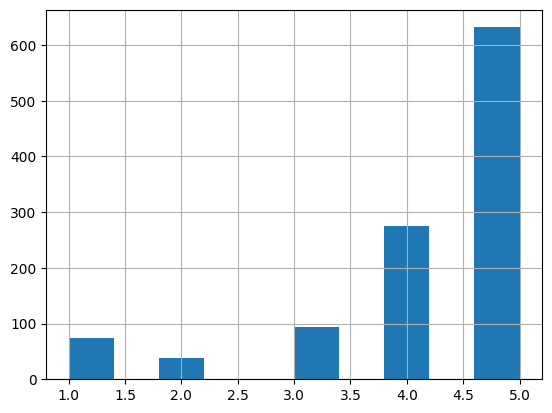

In [15]:
df[df["productId"] == "B00FAX6XQC"]["rating"].hist()

In [16]:
df[df["productId"] == "B00FAX6XQC"]["rating"].mean()

4.212746858168761

::: {.callout-tip icon=true}

### Question 8 (1.0 points)

Haz varios sistemas de recomendación **User-Based** para este conjunto de datos para `k=30` vecinos.

Compara la similitud Pearson con la similitud Coseno. ¿Ayuda el centrado medio?

Comprueba diferentes métricas: RMSE, MAE, Precisión.
:::

In [17]:
ratings_matrix = df.pivot_table(values="rating", index="userId", columns="productId")
ratings_matrix.head()

productId,B00001OWYW,B000ZKA0J6,B0015AARJI,B00178630A,B002I098JE,B0038TT8QM,B003JVCA9Q,B003JVKHEQ,B003VANOFY,B004FYEZMQ,B00503E8S2,B0050SYLRK,B007FTE2VW,B007VTVRFA,B007XVTR3K,B009KS4XRO,B00CMQTVUA,B00D4WTO1M,B00DJFIMW6,B00FAX6XQC
userId,,,,,,,,,,,,,,,,,,,,
A0061198154UGJDK69CYW,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A02210111RNJ8RSJ7F1YO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
A0436342QLT4257JODYJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
A04942912GL09NU0DDO8B,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A05645781CK8V6Y1DOBE6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN


In [18]:
def userknn_cornac(df: pd.DataFrame):

    df = df.astype({"userId": object, "productId": object})
    records = df.to_records(index=False)
    result = list(records)

    K = 30  # number of nearest neighbors
    VERBOSE = False
    SEED = 42
    uknn_cosine = UserKNN(
        k=K, similarity="cosine", name="UserKNN-Cosine", verbose=VERBOSE
    )
    uknn_cosine_mc = UserKNN(
        k=K,
        similarity="cosine",
        mean_centered=True,
        name="UserKNN-Cosine-MC",
        verbose=VERBOSE,
    )
    uknn_pearson = UserKNN(
        k=K, similarity="pearson", name="UserKNN-Pearson", verbose=VERBOSE
    )
    uknn_pearson_mc = UserKNN(
        k=K,
        similarity="pearson",
        mean_centered=True,
        name="UserKNN-Pearson-MC",
        verbose=VERBOSE,
    )

    # Metrics
    rec_300 = cornac.metrics.Recall(k=K)
    rmse = cornac.metrics.RMSE()
    mae = cornac.metrics.MAE()
    prec_30 = cornac.metrics.Precision(k=K)

    ratio_split = RatioSplit(result, test_size=0.1, seed=SEED, verbose=VERBOSE)
    cornac.Experiment(
        eval_method=ratio_split,
        models=[uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
        metrics=[rmse, mae, prec_30, rec_300],
    ).run()

    userknn_models = {
        "uknn_cosine": uknn_cosine,
        "uknn_cosine_mc": uknn_cosine_mc,
        "uknn_pearson": uknn_pearson,
        "uknn_pearson_mc": uknn_pearson_mc,
    }

    return userknn_models


userknn_models = userknn_cornac(df)


TEST:
...
                   |    MAE |   RMSE | Precision@30 | Recall@30 | Train (s) | Test (s)
------------------ + ------ + ------ + ------------ + --------- + --------- + --------
UserKNN-Cosine     | 0.6905 | 0.6905 |       0.0500 |    1.0000 |    1.0813 |   0.0051
UserKNN-Cosine-MC  | 0.6667 | 0.6667 |       0.0500 |    1.0000 |    1.0251 |   0.0083
UserKNN-Pearson    | 0.6667 | 0.6667 |       0.0500 |    1.0000 |    1.0928 |   0.0106
UserKNN-Pearson-MC | 0.6667 | 0.6667 |       0.0500 |    1.0000 |    1.0744 |   0.0055



::: {.callout-tip icon=true}

### Question 9 (0.75 points)

Selecciona un usuario y recomiendale los 10 mejores productos basándote en el modelo de user-based que consideres oportuno dado el entrenamiento.

:::

In [19]:
df_user = pd.read_csv("reduced_video_games.csv").set_index("userId")
df_user.head()

,productId,rating
userId,,
A2BQXTSS8G6ZL2,B001TOQ8UW,5.0
AEJZHD61JTJKK,B0029LJIFG,5.0
A3TY2AEFHQRTWJ,B003O6E1JS,4.0
A8RITE7SJ9GYS,B0000E5U6I,3.0
A1SCCUZEPM657Y,B00DJFIMW6,5.0


In [20]:
df_user.loc["A1SCCUZEPM657Y"]

productId    B00DJFIMW6
rating              5.0
Name: A1SCCUZEPM657Y, dtype: object

In [21]:
df.iloc[4]

userId       A31HGROF3856IH
productId        B00DJFIMW6
rating                  5.0
Name: 120, dtype: object

In [22]:
model = userknn_models.get("uknn_cosine")

In [23]:
def user_profiling(UID, model, user_df, TOPK=5):

    rating_mat = model.train_set.matrix

    UIDX = list(model.train_set.uid_map.items())[UID][0]

    print(f"UserID = {UIDX}")
    print("-" * 35)
    print(user_df.loc[UIDX])

    ratings = pd.DataFrame(rating_mat.toarray())
    user_ratings = ratings.loc[UID]
    top_rated_items = np.argsort(user_ratings)[-TOPK:]
    print(f"\nTOP {TOPK} RATED ITEMS BY USER {UID}:")
    print("-" * 35)
    print(user_df.iloc[top_rated_items.array])


model = userknn_models.get("uknn_cosine")

top_rated_items = user_profiling(4, model, df_user)

UserID = A33I59E9I8YHZK
-----------------------------------
productId    B00DJFIMW6
rating              4.0
Name: A33I59E9I8YHZK, dtype: object

TOP 5 RATED ITEMS BY USER 4:
-----------------------------------
                 productId  rating
userId                            
A8RITE7SJ9GYS   B0000E5U6I     3.0
AEJZHD61JTJKK   B0029LJIFG     5.0
A21S5N7ZEU4QK9  B0016BVY7U     4.0
A1W269IB6MYVT8  B001IYR53W     5.0
A3TY2AEFHQRTWJ  B003O6E1JS     4.0


::: {.callout-tip icon=true}

### Question 10 (1.0 points)
Haz varios sistemas de recomendación **Item-based** para este conjunto de datos para `k=30` vecinos.

Compara la similitud Pearson, la similitud Coseno ajustado y la similitud Coseno. ¿Ayuda el centrado medio?

Comprueba diferentes métricas: RMSE, MAE, Precisión.
:::

In [24]:
def itemknn_cornac(df):
    df = df.astype({"userId": object, "productId": object})
    records = df.to_records(index=False)
    result = list(records)
    K = 50  # number of nearest neighbors
    VERBOSE = False
    SEED = 42
    iknn_cosine = ItemKNN(
        k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE
    )
    iknn_pearson = ItemKNN(
        k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE
    )
    iknn_pearson_mc = ItemKNN(
        k=K,
        similarity="pearson",
        mean_centered=True,
        name="ItemKNN-Pearson-MC",
        verbose=VERBOSE,
    )
    iknn_adjusted = ItemKNN(
        k=K,
        similarity="cosine",
        mean_centered=True,
        name="ItemKNN-AdjustedCosine",
        verbose=VERBOSE,
    )

    # Metrics
    rmse = cornac.metrics.RMSE()
    mae = cornac.metrics.MAE()

    ratio_split = RatioSplit(result, test_size=0.1, seed=SEED, verbose=VERBOSE)
    cornac.Experiment(
        eval_method=ratio_split,
        models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
        metrics=[rmse, mae],
    ).run()
    itemknn_models = {
        "iknn_cosine": iknn_cosine,
        "iknn_pearson": iknn_pearson,
        "iknn_pearson_mc": iknn_pearson_mc,
        "iknn_adjusted": iknn_adjusted,
    }
    return itemknn_models


itemknn_models = itemknn_cornac(df)


TEST:
...
                       |    MAE |   RMSE | Train (s) | Test (s)
---------------------- + ------ + ------ + --------- + --------
ItemKNN-Cosine         | 0.3571 | 0.3571 |    0.0483 |   0.0016
ItemKNN-Pearson        | 0.3571 | 0.3571 |    0.0475 |   0.0015
ItemKNN-Pearson-MC     | 0.3571 | 0.3571 |    0.0477 |   0.0014
ItemKNN-AdjustedCosine | 0.3571 | 0.3571 |    0.0478 |   0.0014



::: {.callout-tip icon=true}

### Question 11 (0.75 points)

Convierte la matriz de ratings pronosticadas en el entrenamiento de tu modelo **Item-Based** favorito en un objeto `pd.DataFrame`.
:::

In [25]:
predicted_ratings = pd.DataFrame(
    model.train_set.matrix.toarray(),
    columns=list(model.train_set.iid_map.items()),
    index=list(model.train_set.uid_map.items()),
)
predicted_ratings.head()

,"(B000ZKA0J6, 0)","(B007VTVRFA, 1)","(B00DJFIMW6, 2)","(B00503E8S2, 3)","(B00178630A, 4)","(B003VANOFY, 5)","(B0050SYLRK, 6)","(B007FTE2VW, 7)","(B004FYEZMQ, 8)","(B00CMQTVUA, 9)","(B00FAX6XQC, 10)","(B0038TT8QM, 11)","(B00001OWYW, 12)","(B003JVCA9Q, 13)","(B00D4WTO1M, 14)","(B009KS4XRO, 15)","(B0015AARJI, 16)","(B003JVKHEQ, 17)","(B002I098JE, 18)","(B007XVTR3K, 19)"
"(A2YYMMJFEG3ZG1, 0)",5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(A196G2C13JQ2EI, 1)",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(A418OINFE4WTM, 2)",0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(A26OALL5BYR5UH, 3)",0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(A33I59E9I8YHZK, 4)",0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


::: {.callout-tip icon=true}

### Question 12 (0.75 points)

¿Qué puntuación recibe el artículo `'B002I098JE` del usuario `'A7B5JEED0RKXG'` según este modelo?

¿Y según el model User-based?

:::

In [26]:
item_model = itemknn_models.get("iknn_adjusted")

In [27]:
item_model.train_set.iid_map.get("B002I098JE")

18

In [28]:
item_model.train_set.uid_map.get("A7B5JEED0RKXG")

40

In [29]:
item_model.score(50, 18)

5.0

::: {.callout-tip icon=true}

### Question 13 (1 points)

Haz un sistema de recomendación utilizando SVD para este dataset con k=100, otro para k=150 y otro para k=200. 

:::

In [30]:
from cornac.models import UserKNN, ItemKNN, SVD


def svd_cornac(df, k_min=5, k_max=2000, step=100):
    df = df.astype({"userId": object, "productId": object})
    records = df.to_records(index=False)
    result = list(records)

    VERBOSE = False
    SEED = 42

    svd_models = []
    k_values = np.arange(k_min, k_max, step)
    for k in k_values:
        svd_models.append(SVD(name="SVD" + str(k), k=k))

    # Metrics
    rmse = cornac.metrics.RMSE()

    ratio_split = RatioSplit(result, test_size=0.1, seed=SEED, verbose=VERBOSE)
    svd_experiment = cornac.Experiment(
        eval_method=ratio_split,
        models=svd_models,
        show_validation=True,
        metrics=[rmse],
    )
    svd_experiment.run()

    return svd_models, svd_experiment


svd_models, svd_experiment = svd_cornac(df, 2, 25, 5)


TEST:
...
      |   RMSE | Train (s) | Test (s)
----- + ------ + --------- + --------
SVD2  | 1.0905 |    0.0022 |   0.0009
SVD7  | 1.0684 |    0.0033 |   0.0007
SVD12 | 1.0512 |    0.0043 |   0.0007
SVD17 | 1.0221 |    0.0049 |   0.0008
SVD22 | 1.0707 |    0.0064 |   0.0007



::: {.callout-tip icon=true}

### Question 14 (0.75 points)

Selecciona uno de los modelos de SVD, elige a un usuario y recomiéndale 5 productos, luego imprime las puntuaciones que les otorgaría a esos productos.

:::

In [31]:
svd = svd_models[0]

In [32]:
def recommend_products(index, model, data, num_products=5):

    print("Name of Model:", svd.name)

    # Rank all test items for a given user.
    df_rank = pd.DataFrame(
        {"ranked_items": model.rank(index)[0], "item_scores": model.rank(index)[1]},
        columns=["ranked_items", "item_scores"],
    )
    print("Target UserId", data.iloc[index].userId)

    df_rank.sort_values("item_scores", ascending=False, inplace=True)

    print(
        "Recommended products:",
        data.iloc[df_rank.head(num_products).ranked_items.values]["productId"].values,
    )
    print("Predicted scoreds: ", df_rank.head(num_products).item_scores.values)


recommend_products(1, svd, df)

Name of Model: SVD2
Target UserId A8WEWLW72ZF3S
Recommended products: ['B00DJFIMW6' 'B00CMQTVUA' 'B002I098JE' 'B0050SYLRK' 'B002I098JE']
Predicted scoreds:  [4.7447906 4.41736   4.0588737 4.053536  3.8982158]


---